In [1]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
#plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
#plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
print(pch.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import scanpy as sc
import glob

1.8.2


In [2]:
print("Scanpy version:", sc.__version__)

Scanpy version: 1.10.4


In [3]:
adata_all = sc.read_h5ad('/home/junyichen/code/scmmd/output/atac0627/3REGIONS_gene.h5ad')


In [4]:
l2meta_name = '/data2st1/junyi/output/atac0627/ATACSC_3REGION_ALL_L2annoated.csv'

if not os.path.exists(l2meta_name):
    print(f"File {l2meta_name} does not exist. Please check the path.")
    adata_sc = sc.read_h5ad("/data1st1/sch/20250626/anndata_before_intergration_anno.h5ad")

    df_ct_nt = adata_sc.obs.loc[:,['Neurotransmitter_celltype','celltype.L1','celltype.L2']].drop_duplicates(subset='celltype.L2')
    df_ct_nt['Neurotransmitter_celltype'] = df_ct_nt['Neurotransmitter_celltype'].fillna('NN')
    f_l2annos = glob.glob('/data2st1/junyi/output/atac0627/ATACSC_*_L2annoated.csv')
    meta_atac = pd.DataFrame()
    for f in f_l2annos:
        df = pd.read_csv(f,index_col=0)
        meta_atac = pd.concat([meta_atac,df],axis=0)
    meta_atac.index = meta_atac.index.str.replace('_query','',regex=False)
    diff_cells = list(set(adata_all.obs.index).difference(set(meta_atac.index)))
    df_l2_nt = dict(zip(df_ct_nt['celltype.L2'],df_ct_nt['Neurotransmitter_celltype'])) 
    df_l2_l1 = dict(zip(df_ct_nt['celltype.L2'],df_ct_nt['celltype.L1']))
    meta_atac_merged = meta_atac.merge(df_ct_nt,how='left',left_on='celltype.L2',right_on='celltype.L2',suffixes=('', '_ct'))
    meta_atac_merged.index = meta_atac.index
    # nnmeta = meta_atac_merged[meta_atac_merged['Neurotransmitter_celltype']=='NN']
    # adata_nn = adata_all[nnmeta.index]
    # adata_nn.obs['celltype.L2'] = nnmeta['celltype.L2'].values

    # adata_nn.obs['celltype.L1_ct'] = nnmeta['celltype.L1_ct'].values
    # adata_nn.obs['equal'] =True
    # adata_nn.obs.loc[adata_nn.obs['celltype.L1'].astype(str) != adata_nn.obs['celltype.L1_ct'].astype(str),'equal'] = False
    # adata_nn.obs.loc[adata_nn.obs['celltype.L1'].astype(str) != adata_nn.obs['celltype.L1_ct'].astype(str)]
    # sc.pl.umap(adata_nn,color=['celltype.L1','celltype.L1_ct','leiden_res_1.9','celltype.L2','equal'],ncols=1,frameon=False,show=False)
    # adata_neuron = adata_all[adata_all.obs['celltype.L1']=='Neuron']
    # #​1. GABAergic Neuron Markers​ and ​2. Glutamatergic Neuron Markers​
    # marker_genes_dict = {
    #     "GABA": ["Slc32a1", "Gad1", "Gad2", "Gabrb3", "Gabra2", "Gabrb2", "Gabrb1", "Gabrq", "Gabrp"],
    #     "Glutamate": ["Slc17a7", "Slc17a6", "Slc17a8", "Slc17a9", "Grin1", "Grin2a", "Grin2b", "Grin2c", "Grin2d", "Gria1", "Gria2", "Gria3"]
    # }

    # sc.pl.dotplot(adata_neuron, marker_genes_dict, "leiden_res_"+str(1.9), dendrogram=False)

    # sc.pl.dotplot(adata_neuron, marker_genes_dict, "leiden_res_"+str(0.5), dendrogram=False)

    merged_df = adata_all.obs.merge(meta_atac_merged[['celltype.L2','Neurotransmitter_celltype','celltype.L1_ct']], left_index=True, right_index=True, suffixes=('', '_meta'),how='left')
    df_missing = merged_df[merged_df.isna().any(axis=1)]
    # Process missing with leiden largest group
    for index, row in df_missing.iterrows():
        sample_name = row['sample']
        leiden_row = row['leiden_res_1.9']
        subset_sample= merged_df[(merged_df['sample'] == sample_name) & (merged_df['leiden_res_1.9'] == leiden_row)]
        top_celltype = subset_sample['celltype.L2'].value_counts().idxmax()
        nt_type = df_l2_nt[top_celltype]
        l1_type = df_l2_l1[top_celltype]
        merged_df.at[index, 'celltype.L2'] = top_celltype
        merged_df.at[index, 'Neurotransmitter_celltype'] = nt_type
        merged_df.at[index, 'celltype.L1_ct'] = l1_type
else:
    merged_df = pd.read_csv(l2meta_name,index_col=0)
    # adata_nn = adata_all[merged_df.index]
    # adata_nn.obs['celltype.L2'] = merged_df['celltype.L2'].values
    # adata_nn.obs['celltype.L1_ct'] = merged_df['celltype.L1_ct'].values
    # adata_nn.obs['equal'] = True
    # adata_nn.obs.loc[adata_nn.obs['celltype.L1'].astype(str) != adata_nn.obs['celltype.L1_ct'].astype(str), 'equal'] = False
    # sc.pl.umap(adata_nn, color=['celltype.L1', 'celltype.L1_ct', 'leiden_res_1.9', 'celltype.L2', 'equal'], ncols=1, frameon=False, show=False)

In [5]:
merged_df.to_csv('/data2st1/junyi/output/atac0627/ATACSC_3REGION_ALL_L2annoated.csv')

In [6]:
assert (merged_df.index == adata_all.obs.index).all()
adata_all.obs = merged_df

[<Axes: title={'center': 'leiden_res_0.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Neurotransmitter_celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

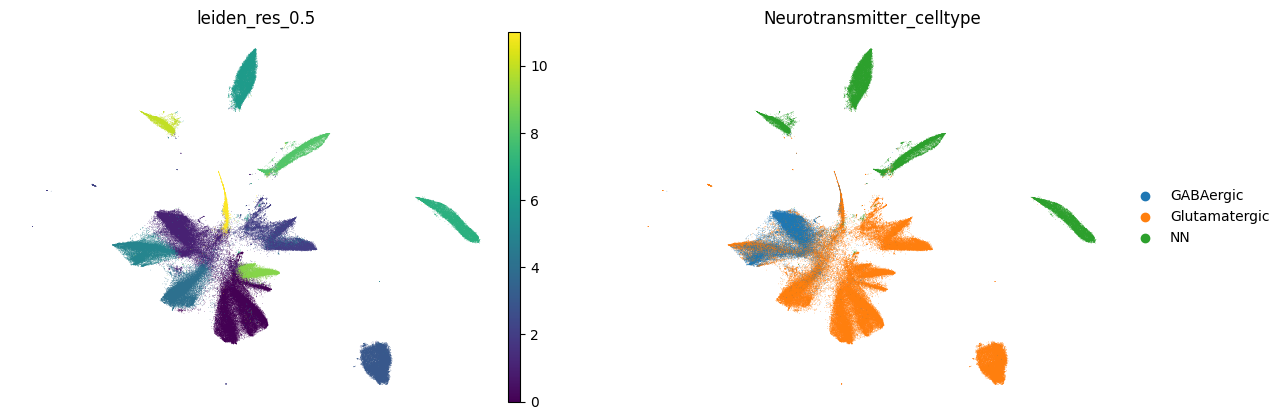

In [7]:
sc.pl.umap(adata_all,color=['leiden_res_0.5','Neurotransmitter_celltype'],frameon=False,show=False)

In [8]:
meta_atac = merged_df

In [9]:
meta_atac['Sample_name'] = meta_atac['sample']
meta_atac['Condition'] = meta_atac['Sample_name'].str[:2]
meta_atac['Region'] = meta_atac['Sample_name'].str.split('_').str[1]

In [10]:
df = meta_atac

In [11]:
cdt = meta_atac.Condition

In [12]:
cdt= meta_atac.loc[:,['Sample_name','Condition']].drop_duplicates(['Sample_name']).set_index('Sample_name')

In [13]:
cdt.sort_values(by='Condition', inplace=True)

In [14]:
cdt.reset_index()

,Sample_name,Condition
0,MC37A_AMY,MC
1,MC39C_HIP,MC
2,MC48D_HIP,MC
3,MC50B_AMY,MC
4,MC50B_HIP,MC
5,MC50B_PFC,MC
6,MC52E_AMY,MC
7,MC52E_PFC,MC
8,MC25A_PFC,MC
9,MW51A_PFC,MW


In [15]:
meta_atac['Neurotransmitter_celltype'] = meta_atac['Neurotransmitter_celltype'].astype('str')
meta_atac['celltype.L1'] = meta_atac['celltype.L1'].astype('str')
meta_atac['Sample_name'] = meta_atac['Sample_name'].astype('str')

/tmp/ipykernel_1055686/1466737680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='Sample_name', ylabel='Proportion (%)'>)

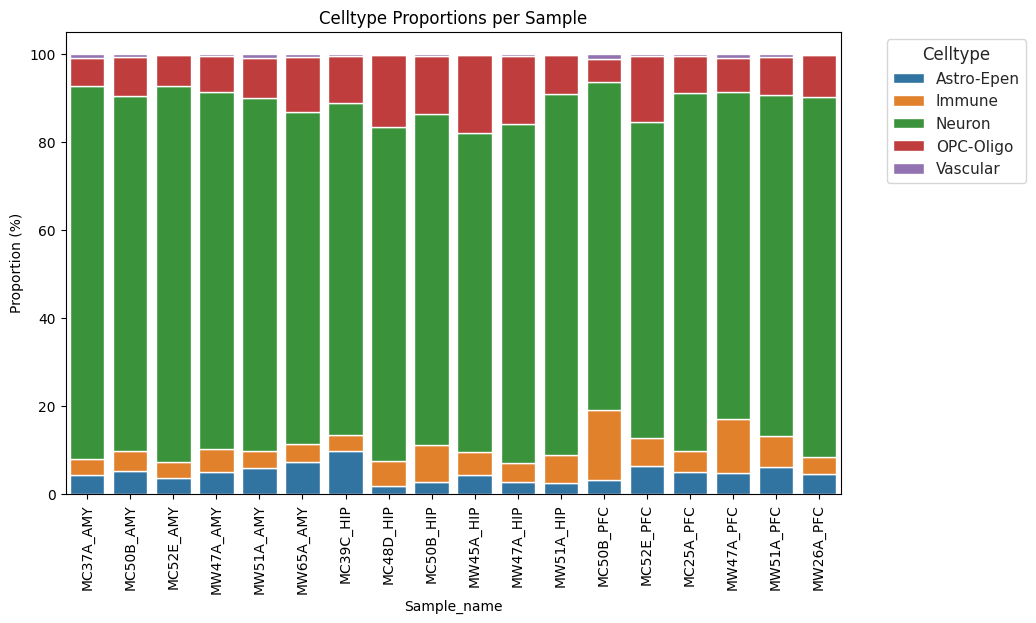

In [16]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i],
            dodge=False
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

order = meta_atac.sort_values(['Region','Condition'])['Sample_name'].unique()
plot_stack_prop(meta_atac,x='Sample_name',color_palette=sns.color_palette("tab10"),x_order=order, figsize=(10, 6))

Starting plotting HeatmapAnnotations


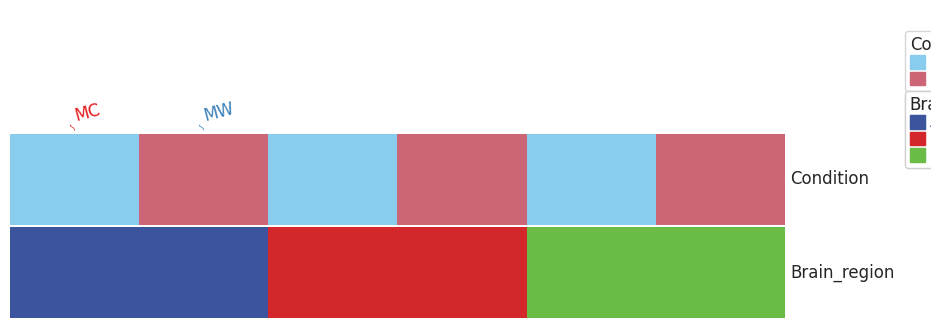

In [17]:
cdt= cdt.loc[order]

br= meta_atac.loc[:,['Sample_name','Region']].drop_duplicates(['Sample_name']).set_index('Sample_name')
plt.figure(figsize=(10, 4))
col_ha = pch.HeatmapAnnotation(
                                label=pch.anno_label(cdt.Condition, merge=True,rotation=15),
                                #Sample_name=pch.anno_simple(ntc.reset_index()['sample'],legend=True), axis=1,

                                 #Sample_name=pch.anno_simple(meta_atac.Sample_name,add_text=True,legend=True),
                                Condition=pch.anno_simple(cdt.Condition, add_text=False,legend=True,text_kws={'color':'black'},cmap='Safe'),
                                Brain_region=pch.anno_simple(br.Region, add_text=False,legend=True,text_kws={'color':'black'},cmap='nature6_2'),

                            #    pro=pch.anno_barplot(df=df_pro.iloc[:,1:],legend=True,cmap='tab10',stacked=True),
                               plot=True,legend=True,legend_gap=0,hgap=0.5)
plt.show()


/tmp/ipykernel_1055686/1466737680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='Sample_name', ylabel='Proportion (%)'>)

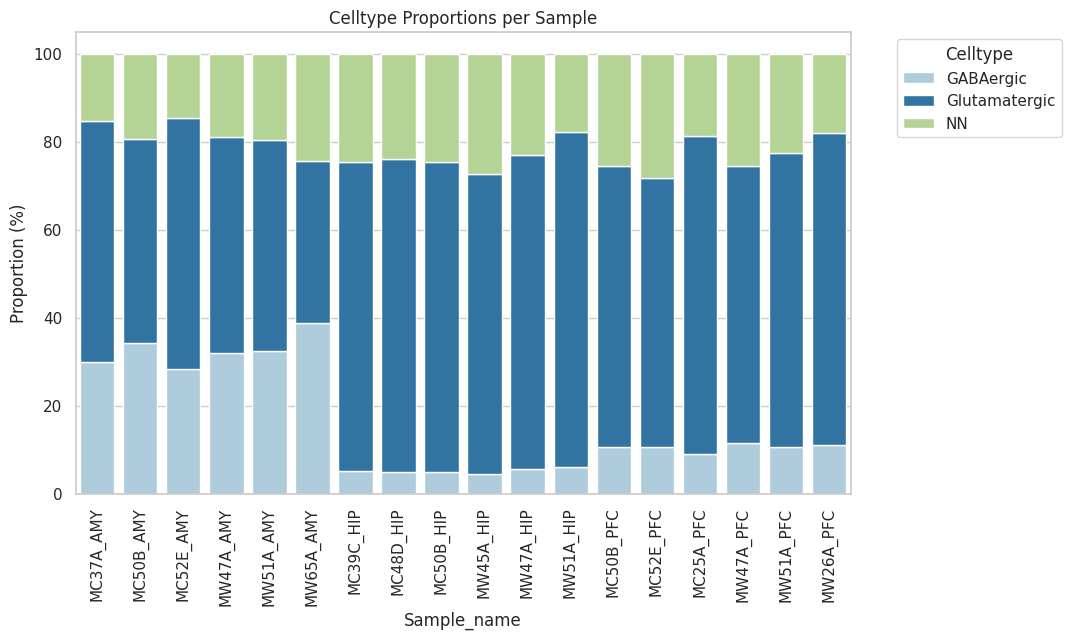

In [18]:
plot_stack_prop(meta_atac,x='Sample_name',pro_col='Neurotransmitter_celltype', y='proportion',color_palette=sns.color_palette("Paired"),x_order=order, figsize=(10, 6))

In [48]:
df_l2_count = meta_atac.groupby(['celltype.L2','Condition']).size().reset_index(name='count').sort_values(by='count', ascending=False)

In [49]:
df_l2_count

,celltype.L2,Condition,count
91,HPF DG GC Glut,MW,12684
90,HPF DG GC Glut,MC,10292
147,PFC L2/3 IT Glut,MW,8980
146,PFC L2/3 IT Glut,MC,8673
83,HPF CA1 Glut,MW,5848
...,...,...,...
77,Endothelial cell-2,MW,4
76,Endothelial cell-2,MC,3
65,Astrocyte-5,MW,3
181,Tanycyte,MW,1


In [50]:
df_l2_nt = dict(zip(meta_atac['celltype.L2'],meta_atac['Neurotransmitter_celltype'])) 
df_l2_l1 = dict(zip(meta_atac['celltype.L2'],meta_atac['celltype.L1']))


In [51]:
df_l2_count['celltype.L1'] = df_l2_count['celltype.L2'].map(df_l2_l1)
df_l2_count['Neurotransmitter_celltype'] = df_l2_count['celltype.L2'].map(df_l2_nt)

In [53]:
df_l2_count

,celltype.L2,Condition,count,celltype.L1,Neurotransmitter_celltype
91,HPF DG GC Glut,MW,12684,Neuron,Glutamatergic
90,HPF DG GC Glut,MC,10292,Neuron,Glutamatergic
147,PFC L2/3 IT Glut,MW,8980,Neuron,Glutamatergic
146,PFC L2/3 IT Glut,MC,8673,Neuron,Glutamatergic
83,HPF CA1 Glut,MW,5848,Neuron,Glutamatergic
...,...,...,...,...,...
77,Endothelial cell-2,MW,4,Vascular,NN
76,Endothelial cell-2,MC,3,Vascular,NN
65,Astrocyte-5,MW,3,OPC-Oligo,NN
181,Tanycyte,MW,1,OPC-Oligo,NN


In [58]:
df_l2_count[df_l2_count['count'] < 200]

,celltype.L2,Condition,count,celltype.L1,Neurotransmitter_celltype
25,AMY Meis1_Gpr149 Glut,MW,177,Neuron,Glutamatergic
161,PFC L6b Glut,MW,163,Neuron,Glutamatergic
38,AMY Tcf7l2_Cachd1 Glut,MC,160,Neuron,Glutamatergic
9,AMY Igfn1_Scube1 Glut,MW,157,Neuron,Glutamatergic
144,PFC Car3 Glut,MC,157,Neuron,Glutamatergic
...,...,...,...,...,...
77,Endothelial cell-2,MW,4,Vascular,NN
76,Endothelial cell-2,MC,3,Vascular,NN
65,Astrocyte-5,MW,3,OPC-Oligo,NN
181,Tanycyte,MW,1,OPC-Oligo,NN


array([[<Axes: title={'center': 'count'}>]], dtype=object)

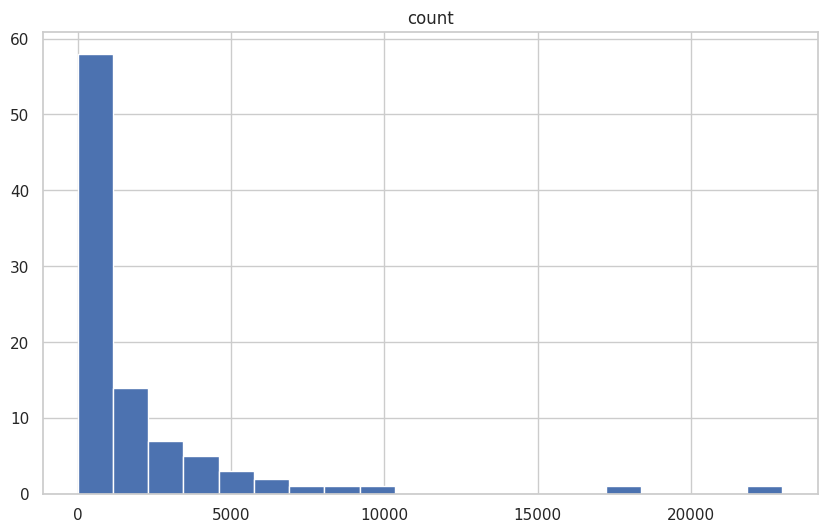

In [35]:
df_l2_count.hist(column='count', bins=20, figsize=(10, 6))

In [179]:
colors = np.random.rand(50, 3)  # 50 colors, each with RGB values
from matplotlib.colors import ListedColormap

# Create a ListedColormap
cmap = ListedColormap(colors)


In [ ]:
# df_marker = pd.read_excel("/data2st1/junyi/output/atac0416/20250423maker list.xlsx")

In [ ]:
# df_all_meta = pd.DataFrame()

# for region in meta_atac['Region'].unique():
#     df_neu = pd.read_csv(f'/data2st1/junyi/output/atac0416/ATACSC_{region}_Neuron_L2annoated.csv', index_col=0)  

#     df_region_marker = df_marker[df_marker['region'] == region]

#     if region == 'PFC':
#         df_neu['celltype.L2'] = "PFC " + df_neu['celltype.L2']
 
#     df_neu_merge = df_neu.merge(df_region_marker, left_on='celltype.L2',right_on='celltype.L2', how='left')
#     df_neu_merge.index = df_neu.index

    
#     if len(df_all_meta) > 0:
#         df_all_meta = pd.concat([df_all_meta, df_neu_merge], axis=0)
#     else:
#         df_all_meta = df_neu_merge

# df_all_meta.index = df_all_meta.index.str.replace('_query', '')

In [ ]:
# df_all_meta

In [ ]:
# adata_all.obs['celltype.L2']=adata_all.obs['celltype.L1'].astype(str)
# adata_all.obs['region'] = adata_all.obs['sample'].str.split('_').str[1]
# adata_all.obs['Neurotransmitter_celltype'] = 'NN'


In [ ]:
# adata_all.obs.loc[df_all_meta.index,'celltype.L2'] = df_all_meta['celltype.L2'].astype(str)

# adata_all.obs.loc[df_all_meta.index,'Neurotransmitter_celltype'] = df_all_meta['Neurotransmitter_celltype'].astype(str)

# adata_all.obs['region_nt'] = adata_all.obs['region'].astype(str) +"_"+ adata_all.obs['Neurotransmitter_celltype'].str[:4].astype(str)
# adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('NN'),'region_nt'] = "NN"
# adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('nan'),'region_nt'] = np.nan

In [185]:
adata_all.obs['region_nt'] = adata_all.obs['Region'].astype(str) + "_" + adata_all.obs['Neurotransmitter_celltype'].str[:4].astype(str)
adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('NN'),'region_nt'] = "NN"

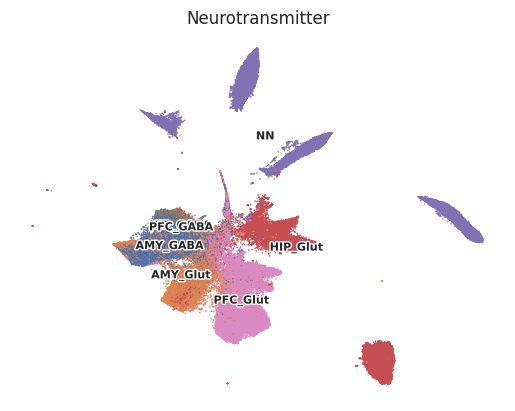

In [194]:
sc.pl.umap(adata_all, color=['region_nt'], size=5, legend_fontsize=8, title='Neurotransmitter', frameon=False, show=True,legend_loc='on data', 
           legend_fontoutline=2,save='01_umap_3region.svg',)

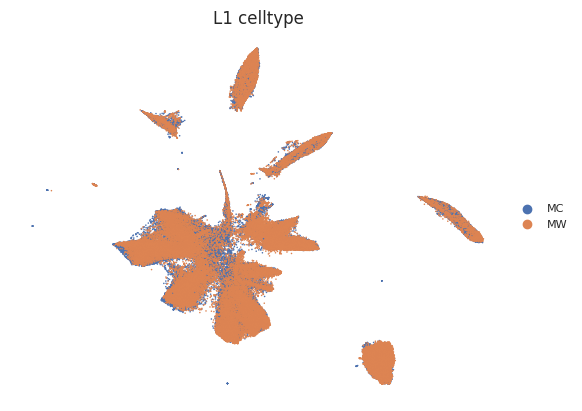

In [199]:
sc.pl.umap(adata_all, color=['Condition'], size=5, legend_fontsize=8, title='L1 celltype', frameon=False, show=True, 
           legend_fontoutline=2,save='01_umap_3region.svg',cmap=cmap)

In [187]:
adata_all.obs.to_csv('/home/junyichen/code/scmmd/output/atac0416/ATACSC_3REGION_ALL_L2annoated.csv')